In [35]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import copy
import time
import numba as nb
from tqdm import tqdm
import unittest


dt = 1000
sim_lim = 1000
skip_points = 10
G = 6.67e-11
error = 1
test3_extra_Bodies = 2

def random_Body():
    return CosmicBody(float(rnd.randrange(1e22, 1e23, 1.0e19)),
                      np.array([float(rnd.randrange(-100000, 100000, 100)),
                                float(rnd.randrange(-100000, 100000, 100)),
                                float(rnd.randrange(-100000, 100000, 100))]),
                      np.array([float(rnd.randrange(-1e11, 1e11, 1e8)),
                                float(rnd.randrange(-1e11, 1e11, 1e8)),
                                float(rnd.randrange(-1e11, 1e11, 1e8))]))
@nb.njit(cache=True, nogil=False, fastmath=True)
def norm(vec: np.ndarray):
    """
    Вычисляет и возвращает норму вектора.
    Parameters
    ----------
    vec : np.ndarray
        Вектор
    Returns
    -------
    norm : np.ndarray
    """
    return np.linalg.norm(vec, ord = 2)

@nb.njit(cache=True, fastmath=True, parallel=True)
def accelerate(M: float, r: np.ndarray):
    """
    Вычисляет и возвращает ускорение.
    Parameters
    ----------
    M : float
        Масса тела.
    r : np.ndarray
        Координаты тела.
    G : float
        Гравитационная постоянная
    Returns
    -------
    acceleration : np.ndarray
    """
    return G * M * r / norm(r) ** 3
    
    
class Star:
    def __init__(self, mass: float, radius = 0.):
        """
        Инициализирует звезду
        Parameters
        ----------
        M : float
            Масса тела.
        r : np.ndarray
            Координаты тела.
        G : float
            Гравитационная постоянная
        Returns
        -------
        None.
        """
        self.mass = mass
        self.vec_P = [0, 0, 0]
        self.radius = radius
        
    def __str__(self):
        return f"Mass:{self.mass} Radius:{self.radius}"

#Class2:  
class CosmicBody:
    def __init__(self, mass: float, vec_v: np.ndarray, vec_P: np.ndarray):
        """
        Инициализирует тело
        Parameters
        ----------
        M : float
            Масса тела.
        v: np.ndarray
            Вектор скорости.
        p : np.ndarray
            Координатный вектор
        Returns
        -------
        None.
        """
        self.mass = mass
        self.vec_v = vec_v
        self.vec_P = vec_P
        self.coords = ([self.vec_P[0], self.vec_P[1], self.vec_P[2]])
        self.destroy_flag = False
        self.id = id(self)
   

    def __str__(self):
        return f"Mass:{self.mass} Velocity:({self.vec_v[0]}, {self.vec_v[1]}, {self.vec_v[2]}) Coordinate:({self.vec_P[0]}, {self.vec_P[1]}, {self.vec_P[2]})"
    
    def E_k(self):
        """
        Возвращает кинетическую энергию тела
        Parameters
        ----------
        ----------
        Returns
        -------
        E_k : float
            кинетическая энергия
        """
        return self.mass * norm(self.vec_v) ** 2 / 2


def try_destroy(self_Body: CosmicBody, Body: [CosmicBody, Star]):
    """
    Пробует уничтожить(и удалить из системы) тела
    Parameters
    ----------
    self_Body : CosmicBody
        Первое тело
    Body : [CosmicBody, Star]
        Список тел
    Returns
    -------
    None.
    """
    if isinstance(Body, Star):
        if norm(self_Body.vec_P - Body.vec_P) < 1000:
            self_Body.destroy_flag = True
    else:
        if norm(self_Body.vec_P - Body.vec_P) < 1000:
            Body.destroy_flag = True
            self_Body.destroy_flag = True

def gravitate(star: Star, Bodies: list):
    """
    Функция описывающая логику движения тела(или списка тела) под действием гравитации, создаваемой звездой
    Parameters
    ----------
    star : Star
        Звезда
    bodies : list
        Список тел
    Returns
    -------
    None.
    """
    Bodies_copy = copy.deepcopy(Bodies)
    for Body, Body_copy in zip(Bodies, Bodies_copy):
        try_destroy(Body, star)
        Body_copy.destroy_flag = Body.destroy_flag
        if Body.destroy_flag == True:
            continue
        dv = accelerate(star.mass, - Body.vec_P) * dt
        Body.vec_v += dv
        Body.vec_P += Body.vec_v * dt
        for NEW_Body in Bodies:
            if NEW_Body.id != Body.id:
                try_destroy(Body, NEW_Body)
                Body_copy.destroy_flag = Body.destroy_flag
        for Body1 in Bodies_copy:
            if Body1.id == Body.id or Body1.id == True:
                continue
            dv = accelerate(Body1.mass, Body_copy.vec_P - Body1.vec_P)*dt
            Body.vec_v += dv
            Body.vec_P += Body.vec_v * dt
        Body.coords = np.column_stack((Body.coords, [Body.vec_P[0], Body.vec_P[1], Body.vec_P[2]]))
                 
def E_p(Body1, Body2):
    """
    Возвращает потенциальную энергию тела
    ----------
    Returns
    -------
    E_p : float
        потенциальная энергия
    """
    return G * Body1.mass * Body2.mass / norm(Body1.vec_P - Body2.vec_P)

def E_full(star: Star, Bodies: np.ndarray):
    """
    Возвращает полную энергию системы
    ----------
    star : Star
    Bodies : np.ndarray
        Список тел
    Returns
    -------
    E : float
        полная энергия системы
    """
    E = 0
    for i in range(len(Bodies)):
        E += E_p(Bodies[i], star) + Bodies[i].E_k()
        for j in range(i + 1, len(Bodies)):
            E += E_p(Bodies[i], Bodies[j])
    return E

def orbit_type(star: Star, Body: CosmicBody):
    E = E_p(star, Body) - Body.E_k()
    if E > 0:
        return 'Elliptic'
    elif E < 0:
        return 'Hyperbolic(Leaves an interaction area)'
    else:
        return 'Parabolic(Leaves an interaction area)'    

    
system_of_2 = np.array([random_Body(), random_Body()])
system_of_2_copy = copy.deepcopy(system_of_2)
system_of_3 = np.array([random_Body(), random_Body(), random_Body()])
system_of_4 = np.array([random_Body(), random_Body(), random_Body(), random_Body()])
Earth = CosmicBody(1e23, np.array([4., 2., 8.]), np.array([1., 2., 3.]))
Сириус = Star(1e31)
zero = Star(0)

class TestFunctions(unittest.TestCase):
    def test_E_p(self):
        Body1 = CosmicBody(1e6, np.array([1000., 0., 0.]), np.array([3e3, 0., 0.]))
        Body2 = CosmicBody(1e6, np.array([1000., 0., 0.]), np.array([1e3, 0, 0.]))
        self.assertAlmostEqual(E_p(Body1, Body2), 3.35e-2, 2)

    def test_E_full(self):
        Body1 = CosmicBody(1e6, np.array([100., 0., 0.]), np.array([0., 0., 2e3]))
        Body2 = CosmicBody(1e6, np.array([100., 0., 0.]), np.array([0., 0., 1e3]))
        self.assertAlmostEqual(E_full(Star(0), [Body1, Body2]), 1e10 + 6.67e-2, 2)

unittest.main(argv=['first-arg-is-ignored'], exit=False)

..
----------------------------------------------------------------------
Ran 2 tests in 0.070s

OK


In [30]:
#Проверка ЗСЭ
def test1(star, Bodies: np.ndarray):
    print('Test №1: Energy error estimation')
    E_initial = E_full(star, Bodies)
    print('Original system full energy:', E_initial)
    i = 0
    E_arr = []
    while np.abs(E_full(star, Bodies)/E_initial - 1) < error and i < sim_lim:
        gravitate(star, Bodies)
        i += 1
        E_arr.append(E_full(star, Bodies))
    print('Finite system full energy:', E_full(star, Bodies))
    if i == sim_lim:
        print(
            f"For {i} iterations we have {round(np.abs(E_full(star, Bodies)/E_initial - 1)*100,1)}% relative error guaranteed")
    else:
        print(f"For {i} iterations needed to guarantee {round(error*100,1)}% relative error(sad)")

test1(Сириус, system_of_2)

Test №1: Energy error estimation
Original system full energy: 1.1875558248051293e+33
Finite system full energy: 2.3877052100862733e+33
For 204 iterations needed to guarantee 100% relative error(sad)


In [31]:
#Проверка на уничтожение
def test2(Body1, Body2):
    print('\nTest №2:')
    try_destroy(Earth, Сириус)
    if Earth.destroy_flag == True: 
        print('Destructed sucsessfully')
    else: print('Missed')
    
test2(Earth, Сириус)


Test №2:
Destructed sucsessfully



Test №3:
Mass:3.753e+22 Velocity:(-99900.0, 83800.0, -85600.0) Coordinate:(-29600000000.0, -25200000000.0, 79700000000.0)
Mass:9.798e+22 Velocity:(45300.0, -57500.0, 8100.0) Coordinate:(63400000000.0, -8800000000.0, 34100000000.0)


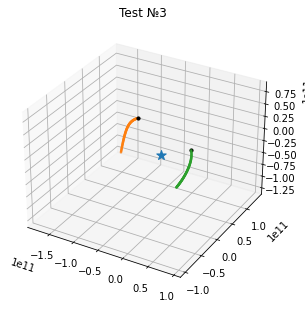

In [4]:
#Действие gravitate со звездой
def test3(star, Bodies: np.ndarray):
    print('\nTest №3:')
    for Body in Bodies:
        print(Body)
    for i in range(sim_lim):
        gravitate(star, Bodies)
        
def test3plot(star, Bodies: np.ndarray):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111, projection='3d')
    if star.mass != 0:
        ax.scatter(0, 0, 0, marker='*', s=100)
    for Body in Bodies:
        ax.scatter(Body.coords[0][::skip_points], Body.coords[1][::skip_points],
                   Body.coords[2][::skip_points], marker='.', s=10)
        ax.scatter(Body.coords[0][0], Body.coords[1]
                   [0], Body.coords[2][0], color='black', label='spawn point', s = 10)
    ax.set_title('Test №3')
    ([float(rnd.randrange(-100000, 100000, 100)),
                                float(rnd.randrange(-100000, 100000, 100)),
                                float(rnd.randrange(-100000, 100000, 100))])
test3(Сириус, system_of_2_copy)
test3plot(Сириус, system_of_2_copy)



Test №4: adding bodies in random time
Random timings: [758000 921000]


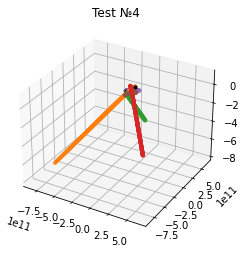

In [5]:
#Проверим моделирование системы, когда в случайные моменты времени появляются новые тела
def test4(star, Bodies: np.ndarray):
    print('\nTest №4: adding bodies in random time')
    time = np.array(
        [rnd.randrange(0, sim_lim, 1) * dt for j in range(test3_extra_Bodies)])
    time.sort()
    print('Random timings:', time)
    for t in range(sim_lim):
        if float(t) * dt in time:
            something = random_Body()
            Bodies = np.append(Bodies, something)
        for Body in Bodies:
            gravitate(star, Bodies)
    return Bodies

def test4_plot(star, Bodies: np.ndarray):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    if star.mass != 0:
        ax.scatter(0, 0, 0, marker='*', s=100)
    for Body in Bodies:
        ax.scatter(Body.coords[0][::skip_points], Body.coords[1][::skip_points],
                   Body.coords[2][::skip_points], s = 10)
        ax.scatter(Body.coords[0][0], Body.coords[1]
                   [0], Body.coords[2][0], color = 'Black', label = 'spawn point', s=10)
    ax.set_title('Test №4')
    
    
    
test4_res = test4(Сириус, system_of_3)
test4_plot(Сириус, test4_res)


Test №5: testing orbyt_type function
Elliptic


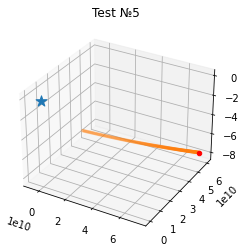

In [6]:
#Проверяем работу функции проверки типа орбиты
def test5(star, Body):
    print('\nTest №5: testing orbyt_type function')
    print(orbit_type(star, Body))
    for i in range(sim_lim):
        gravitate(star, np.array([Body]))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(star.vec_P[0], star.vec_P[1], star.vec_P[2], marker='*', s = 130)
    ax.scatter(Body.coords[0][::skip_points], Body.coords[1][::skip_points],
                   Body.coords[2][::skip_points], s=7)
    ax.scatter(Body.coords[0][0], Body.coords[1]
               [0], Body.coords[2][0], color='red', label = 'spawn point')
    ax.set_title('Test №5')
    
Body = random_Body()
test5(Сириус, Body)

    

<IPython.core.display.Javascript object>


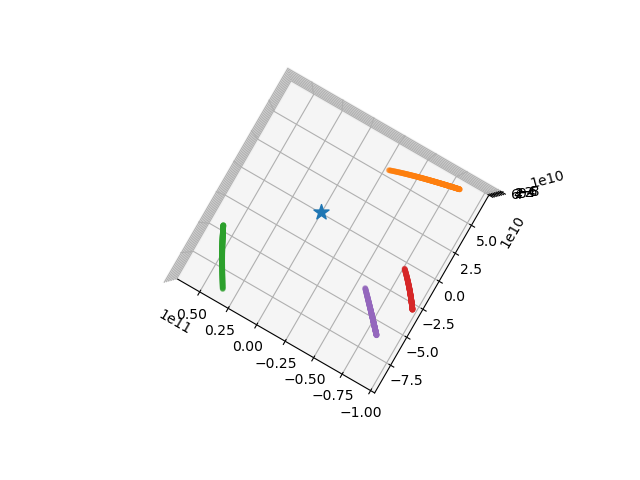

 16%|██████▏                                | 159/1000 [00:28<02:32,  5.53it/s]

In [ ]:
%matplotlib notebook
def test_animation(star: Star, Bodies: np.ndarray):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    fig.show()
    fig.canvas.draw()
    
    for t in tqdm(np.arange(0., sim_lim * dt, dt)):
        angle = 60 + 60 * t / sim_lim 
        gravitate(star, Bodies)
        ax.clear()
        
        ax.scatter(0, 0, 0, marker = '*', s = 130)
        for Body in Bodies:
            ax.scatter(Body.coords[0][::int(skip_points/10)], Body.coords[1][::int(skip_points/10)],
                   Body.coords[2][::int(skip_points/10)], s = 10)
        ax.view_init(30 - angle * 0.2, angle)
        fig.canvas.draw()
    
test_animation(Сириус, system_of_4)